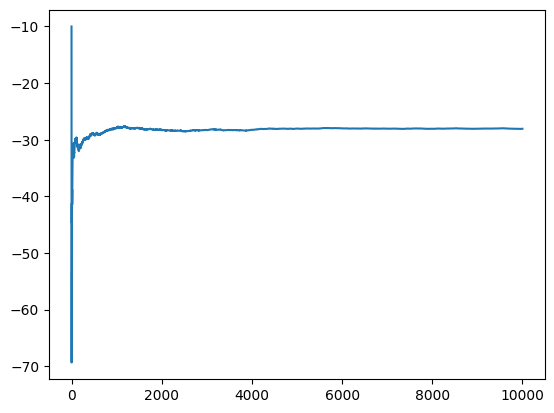

In [1]:
#Task 1.1
from time import sleep
from typing import Optional
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from commons import AbstractAgent, AbstractRLTask, get_crop_chars_from_observation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display
import torch

class GridWorld(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array']}
    reward_range = (-float("inf"), float("inf"))
    spec = None

    def __init__(self, n, m):
        super(GridWorld, self).__init__()
        self.n = n
        self.m = m
        self.action_space = spaces.Discrete(4)  # Up, Down, Right, Left
        self.observation_space = spaces.Tuple((spaces.Discrete(n), spaces.Discrete(m)))

        # Agent starts at (0, 0) and goal is at (n-1, m-1)
        self.position = (0, 0)
        self.goal = (n - 1, m - 1)

    #Run one timestep of the environment's dynamics. 
    #When end of episode is reached, you are responsible for calling `reset()` to reset this environment's state.
    def step(self, action):
        # Dictionary mapping actions to movements
        actions = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, 1),   # Right
            3: (1, -1)   # Left
        }

        # Perform action
        movement = actions[action]
        new_position = (self.position[1] + movement[1], self.position[1] + movement[1])

        # Check if new position is within grid
        if 1 <= new_position[1] < self.n and 0 <= new_position[1] < self.m:
            self.position = new_position
           
        #observation (object): agent's observation of the current environment    
        observation = self.position
        
        #reward (float) : amount of reward returned after previous action
        reward = -1
        
        #done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        done = self.position == self.goal
        
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, logging, and sometimes learning)
        info = []

        return (observation, reward, done, info)

    #Resets the environment to an initial state and returns an initial observation.
    def reset(self,*, seed: Optional[int] = None, return_info: bool = False, 
              options: Optional[dict] = None):

        # Initialize the RNG if the seed is manually passed
        if seed is not None:
           self._np_random, seed = seeding.np_random(seed)

        self.position = (0,0)
        observation = self

        #info (optional dictionary): a dictionary containing extra information
        #this is only returned if return_info is set to true
        info = []

        if return_info:
            return observation, info
        return observation

    def render(self, mode="human"):
        """Renders the environment.

        The set of supported modes varies per environment. (And some
        third-party environments may not support rendering at all.)
        By convention, if mode is:

        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        """


        if mode == 'rgb_array':
            # Render the grid world as an RGB array
            rgb_array = np.zeros((self.n, self.m, 3), dtype=np.uint8)
            rgb_array[self.position] = [255, 0, 0]  # Red color for agent
            rgb_array[self.goal] = [0, 255, 0]   # Green color for goal

            return rgb_array
        
        # Initialize the ANSI character array
        ansi_grid = np.full((self.n, self.m), '.', dtype=str)  # Fill with '.'

        # Place the agent and goal
        ansi_grid[self.position] = '@'  # Agent
        ansi_grid[self.goal] = '>'  # Goal

        #ansi_grid = '\n'.join([''.join(row) for row in ansi_grid])
        
        if mode == 'ansi':
            return ansi_grid
        
        elif mode == 'human':
            print('\n'.join([' '.join(row) for row in ansi_grid]))
        
        else:
            super(GridWorld, self).render(mode=mode) # just raise an exception

class RLTask(AbstractRLTask):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent

    def interact(self, n_episodes):
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []
        
        for k in range(n_episodes+1):
            episode_return = 0  # Initialize episode return
            state = self.env.reset()  # Reset the environment
            done = False
            SAR = []

            while not done:
                #print(get_crop_chars_from_observation(state))
                action = self.agent.act(state)  # Get action from the agent
                next_state, reward, done, _ = self.env.step(action)  # Take action in the environment
                SAR.append((state, action, reward))
                episode_return += reward  # Accumulate reward for the episode
                state = next_state  # Update observation for the next step
            
            sum_returns = sum_returns + episode_return
            Gk = 1 / (k + 1) * sum_returns

            average_returns.append(Gk)  # Store episode return
            k = k + 1

        #Gk = 1 / (k + 1) * sum(Gi)

        self.agent.onEpisodeEnd(self.agent, SAR)
        
        return average_returns

    def interactGPU(self, n_episodes):
        device = "cuda"
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []

        for k in range(n_episodes):
            episode_return = 0  # Initialize episode return
            state = self.env.reset()  # Reset the environment
            done = False
            SAR = []

            while not done:
                # Move state to GPU if not already
                state_tensor = torch.tensor(state).to(device)
                
                # Get action from the agent
                action = self.agent.act(state_tensor)  # Get action from the agent
                
                # Take action in the environment
                next_state, reward, done, _ = self.env.step(action)
                
                # Move next_state to GPU if not already
                next_state_tensor = torch.tensor(next_state).to(device)
                
                # Store the SAR tuple
                SAR.append((state_tensor, action, reward))
                
                # Accumulate reward for the episode
                episode_return += reward  
                
                # Update observation for the next step
                state = next_state  
            
            # Accumulate returns
            sum_returns = sum_returns + episode_return
            
            # Calculate Gk
            Gk = 1 / (k + 1) * sum_returns
            
            # Store episode return
            average_returns.append(Gk)  
            
            k = k + 1

        # Call agent's onEpisodeEnd method
        self.agent.onEpisodeEnd(self.agent, SAR)

    def visualize_episode(self, max_number_steps = None):
        """
        This function executes and plot an episode (or a fixed number 'max_number_steps' steps).
        You may want to disable some agent behaviours when visualizing(e.g. self.agent.learning = False)
        :param max_number_steps: Optional, maximum number of steps to plot.
        :return:
        """
        obs = self.env.reset()  # Reset the environment
        done = False
        steps = 0
        
        plt.ioff()  # Turn off interactive mode to prevent additional plot

        frames = []
        while not done and (max_number_steps is None or steps < max_number_steps):
            uncroppedFrame = self.env.render('ansi')  # Render the environment
            
            if isinstance(uncroppedFrame, np.ndarray):
                frames.append(uncroppedFrame)
            
            else:
                croppedFrame = get_crop_chars_from_observation(obs)

                croppedFrame = [[chr(item) for item in row] for row in croppedFrame]
                
                frames.append(croppedFrame)



            action = self.agent.act(obs)  # Get action from the agent
            obs, _, done, _ = self.env.step(action)  # Take action in the environment
            steps += 1

        # Convert the ANSI arrays to lists of lists of strings
        frames = [[[str(cell) for cell in row] for row in array] for array in frames]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Create a text object with the initial ANSI array
        text = ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')

        # Hide the axis
        ax.axis('off')

        # Get the size of the ANSI array
        n_rows, n_cols = len(frames[0]), len(frames[0][0])

        # Set figure size to fit the text
        fig.set_size_inches(n_cols/3, n_rows/3)

        # Animation function
        def animate(i):
            # Update the text object with the next frame of the ANSI array
            text.set_text('\n'.join([' '.join(row) for row in frames[i]]))

        # Create animation
        ani = FuncAnimation(fig, animate, frames=len(frames), interval=100, repeat=True)

        # Display animation in Jupyter Notebook
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

        # Reset agent learning status after visualization
        self.agent.learning = True

        #close plot to prevent overlaps
        plt.close()

class RandomAgent(AbstractAgent):
    def act(self, state, reward=-1):
        # Randomly select an action from the action space
        return self.action_space.sample()
    

Grid5x5 = GridWorld(5,5)

randAgent = RandomAgent(1,Grid5x5.action_space)

task = RLTask(Grid5x5,randAgent)

returns = task.interact(10000)
randInteract = plt.show(plt.plot(returns))

# Clear the current figure to prevent overlap
plt.close()

randVisualise = task.visualize_episode(100)

In [2]:
#Task 1.2
from commons import get_crop_chars_from_observation
from minihack_env import get_minihack_envirnment

class FixedAgent(AbstractAgent):
    def act(self, state, reward=0):
        #print(state)
        croppedstate = get_crop_chars_from_observation(state)
        #print(croppedstate)
        char_array = np.char.mod('%c', croppedstate)
        #print(char_array)
        if not (64 in croppedstate[-1]) and not ((croppedstate[-2] == 64).any() and croppedstate[-1][(croppedstate[-2] == 64).nonzero()[0][0]] == 45): #go down if you can
            return 2 #right

        else:  #otherwise go right
            return 1 #down

emptyRoom = get_minihack_envirnment("empty-room")
lavaRoom = get_minihack_envirnment("room-with-lava")

fixAgent = FixedAgent(1, emptyRoom.action_space)  

task = RLTask(emptyRoom,fixAgent)
emptyVisualise = task.visualize_episode(10) 

task = RLTask(lavaRoom,fixAgent)
lavaVisualise = task.visualize_episode(10) 


In [3]:
#Task 2.1
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import copy
import random
import time
from IPython.display import display

modelReturns = [1,2,3,4] # to save lists of environment returns per model

def campaign(agent,environments, length):
    envReturns = []
    initEpsilon = agent.epsilon
    for env in environments:
        task = RLTask(env, agent)
        print('Interacting', type(agent).__name__,'with', type(env).__name__)
        start = time.time()   

        returns = task.interact(length)
        # interactPlot = plt.show(plt.plot(returns))
        
        end = time.time()
        print("Interaction took: {:.4f} seconds".format(end - start))

        # Clear the current figure to prevent overlap
        plt.close()

        print('Visualising')
        start = time.time()
        visualisePlot = task.visualize_episode()
        end = time.time()
        print("Visualising took: {:.4f} seconds".format(end - start))

        plt.close()

        #reset the agents q table
        agent.q_table = defaultdict(lambda: [0] * agent.action_space.n)
        agent.epsilon = initEpsilon #reset epsilon after annealing

        envReturns.append(returns)
    return envReturns

def campaign_parallel(agent, environments, length):
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit interact() method for each environment to the thread pool
        futures = [executor.submit(RLTask(env, agent).interact, length) for env in environments]
        
        # Wait for all futures to complete and store only the average returns
        results = [future.result() for future in futures]
        
        # Visualize episodes and reset the agent's Q-table
        for avg_return, env in zip(results, environments):
            randInteract = plt.show(plt.plot(avg_return))
            task = RLTask(env, agent)
            
            # Visualize episode
            task.visualize_episode(100)
            
            # Reset the agent's Q-table
            agent.q_table = defaultdict(lambda: [0] * agent.action_space.n)


In [4]:
class RLTask(AbstractRLTask):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.lastState = None
        self.lastObservation = None
        self.episodes = []
    
    def observe(self, state):
        #if state is the same as the last state use previous observation
        if self.lastState is not None:
            if np.array_equal(state['chars'],self.lastState['chars']):
                return self.lastObservation
        observation = get_crop_chars_from_observation(state)

        # Pad the space with blanks
        observation = np.pad(observation, 1, constant_values=32)

        if 64 not in observation or 62 not in observation:
        # If either 64 or 62 is not present, return a default observation
            location = [0,0]
            goal = [0,0]
        else:
            location = np.argwhere(observation == 64)[0]
            goal = np.argwhere(observation == 62)[0]

        delta_x = goal[1] - location[1]
        delta_y = goal[0] - location[0]

        goal_direction = [delta_x > 0, delta_y > 0]

        #grid 3x3 grid centered on character
        # Generate the grid around point 64
        row_start = max(0, location[0] - 1)
        row_end = min(observation.shape[0], location[0] + 2)
        col_start = max(0, location[1] - 1)
        col_end = min(observation.shape[1], location[1] + 2)
        
        grid_around_character = observation[row_start:row_end, col_start:col_end]
        # Flatten the grid and convert to a tuple
        flattened_grid = grid_around_character.flatten()
        
        # Generate the identifier tuple
        #observation = tuple(np.append(flattened_grid, goal_direction))
        observation = tuple(flattened_grid)
        self.lastObservation = observation
        self.lastState = copy.deepcopy(state)
        return observation
    
    # def observe(self, state):
    #     observation = get_crop_chars_from_observation(state)     
    #     observation = tuple(observation.flatten())
    #     return observation
    
    def interact(self, n_episodes):
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []

        for k in range(n_episodes):
            episode_return = 0  # Initialize episode return
            state = self.env.reset()# Reset the environment

            #format state based on observation function
            state = self.observe(state)

            done = False
            SAR = []

            while not done:
                action = self.agent.act(state)  # Get action from the agent
                
                next_state, reward, done, _ = self.env.step(action)  # Take action in the environment

                if done:
                    break

                next_state = self.observe(next_state)

                SAR.append((state, action, reward))
                episode_return += reward  # Accumulate reward for the episode
                
                #update q value after step, not used in monte carlo
                self.agent.update_Q(state, action, reward, next_state)      

                state = next_state  # Update observation for the next step

            sum_returns = sum_returns + episode_return
            Gk = 1 / (k + 1) * sum_returns

            average_returns.append(Gk)  # Store episode return
            k = k + 1

            #Gk = 1 / (k + 1) * sum(Gi)
            self.agent.onEpisodeEnd(self.agent, SAR)
            self.agent.epsilon = 0.1 - (0.1 - 0.01) / 1000 * k
    
        return average_returns
    
    # def visualize_episode(self, episodes, max_number_steps = 100):
    #     plt.close()
    #     array_length = len(episodes)-1
    #     num_picks = 2

    #     step_size = array_length / (num_picks - 1)

    #     equidistant_picks = [int(i * step_size) for i in range(num_picks)]
    #     all_frames = []
    #     for i in range(num_picks):
    #         episode = episodes[equidistant_picks[i]]            
    #         frames = []
    #         while len(frames) < max_number_steps:
    #             for state in episode:
    #                 frame = get_crop_chars_from_observation(state)
    #                 frame = [[str(chr(item)) for item in row] for row in frame]
    #                 frames.append(frame)
                
    #         all_frames.append(frames)
            
    #     max_length = max(len(episode) for episode in all_frames)

    #     # Calculate the number of frames to add to each list
    #     frames_to_add = max_length - max(len(frames) for frames in all_frames)

    #     # Extend each list of frames with copies of their last frame
    #     all_frames = [frames + [frames[-1]] * frames_to_add for frames in all_frames]
            
    #     # Create figure and subplots
    #     fig, axs = plt.subplots(num_picks // 2, 2)

    #     n_rows, n_cols = len(frames[0]), len(frames[0][0]) # Get the size of the ANSI array
    #     fig.set_size_inches(n_cols/2 * 2, num_picks * n_rows/2) # Set figure size to fit the text  
                    
    #     # Define animation function for each subplot
    #     def animate(i):
    #         text = {}
    #         for j in range(num_picks):
    #             # Animation for subplot 1
    #             axs[j].clear()
    #             axs[j].set_title(f"Episode {round(j * step_size + 0.5)}")
    #             axs[j].axis('off') # Hide the axis
                
    #             # Create a text object with the initial ANSI array
    #             text[j] = axs[j].text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')
    #             text[j].set_text('\n'.join([' '.join(row) for row in all_frames[j][i]]))
            
    #     # Create animation
    #     ani = FuncAnimation(fig, animate, frames=max_length, interval=100, repeat=True)

    #     # Display animation in Jupyter Notebook
    #     from IPython.display import HTML, display
    #     display(HTML(ani.to_jshtml()))

    #     # Reset agent learning status after visualization
    #     self.agent.learning = True

    #     #close plot to prevent overlaps
    #     plt.close()
        
    def visualize_episode(self, max_number_steps = 100):
            plt.close()

            done = False
            state = self.env.reset()# Reset the environment
            observation = self.observe(state)
            states = [copy.deepcopy(state)]
            i = 0
            while not done and i <= max_number_steps:
                action = self.agent.act(observation)  # Get action from the agent
                
                next_state, _, done, _ = self.env.step(action)  # Take action in the environment

                if done:
                    break

                states.append(copy.deepcopy(state))

                next_state = self.observe(next_state)
                observation = next_state  # Update observation for the next step
                i = i + 1
            
            #formatting states as frames for animation
            frames = []
            for state in states:           
                frame = get_crop_chars_from_observation(state)
                frame = [[str(chr(item)) for item in row] for row in frame]
                frames.append(frame)
                if len(frames) > max_number_steps:    
                    break
 
            # Create figure and subplots
            fig, axs = plt.subplots()

            n_rows, n_cols = len(frames[0]), len(frames[0][0]) # Get the size of the ANSI array
            fig.set_size_inches(n_cols/3, n_rows/3) # Set figure size to fit the text  
                        
            # Define animation function for each subplot
            def animate(i):
                axs.clear()
                axs.set_title("Episode without learning")
                axs.axis('off') # Hide the axis
                
                # Create a text object with the initial ANSI array
                text = axs.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')
                text.set_text('\n'.join([' '.join(row) for row in frames[i]]))
                
            # Create animation
            ani = FuncAnimation(fig, animate, frames=len(frames), interval=100, repeat=True)

            # Display animation in Jupyter Notebook
            from IPython.display import HTML, display
            display(HTML(ani.to_jshtml()))

            #close plot to prevent overlaps
            plt.close()

class RLAgent():
    def __init__(self, action_space, epsilon = 0.1, gamma = 0.99):
        self.action_space = action_space
        self.q_table = defaultdict(lambda: [0] * action_space.n)
        self.epsilon = epsilon #exploration factor
        self.gamma = gamma  #discount factor
        
        self.learning = True

        self.lastState = None
        self.lastObservation = None
        self.episodes = []
    
    def update_Q(self, state, action, reward, next_state):
        pass
        
    # def act(self, state):
    #     state = state
    #     q_values = self.q_table[state]
    #     # Ensure that q_values has a default value for each action

    #     if (random.random() < self.epsilon) and self.learning:
    #         # Choose a random action
    #         return self.action_space.sample()
    #     else:
    #         # Choose the action with the highest Q-value
    #         max_q_value = np.max(q_values)
    #         max_q_indices = np.where(q_values == max_q_value)[0]

    #         return np.random.choice(max_q_indices)
        
    def act(self, state):
        q_values = self.q_table[state]
        
        if (random.random() < self.epsilon) and self.learning:
            # Choose a random action
            return self.action_space.sample()
        else:
            # Softmax action selection
            softmax_probabilities = self.softmax(q_values)
            action = np.random.choice(len(q_values), p=softmax_probabilities)
            return action

    def softmax(self, q_values):
        # Softmax function to compute probabilities
        exp_q_values = np.exp(q_values / self.temperature)
        probabilities = exp_q_values / np.sum(exp_q_values)
        return probabilities

    def onEpisodeEnd(_, agent, SAR):
        pass

# class RLAgent():
#     def __init__(self, env, epsilon):
#         self.action_space = env.action_space
#         self.q_table = defaultdict(lambda: [0] * self.action_space.n)
#         self.epsilon = epsilon  
#         self.learning = True
    
#     def update_Q(self, state, action, reward, next_state):
#         pass
        
#     def act(self, state):
#         state = state
#         q_values = self.q_table[state]
#         # Ensure that q_values has a default value for each action

#         if (random.random() < self.epsilon) and self.learning:
#             # Choose a random action
#             return self.action_space.sample()
#         else:
#             # Choose the action with the highest Q-value
#             max_q_value = np.max(q_values)
#             max_q_indices = np.where(q_values == max_q_value)[0]

#             return np.random.choice(max_q_indices)

#     def onEpisodeEnd(_, agent, SAR):
#         pass    

#     def observe(self, state):
#         #if state is the same as the last state use previous observation
#         if self.lastState is not None:
#             if np.array_equal(state['chars'],self.lastState['chars']):
#                 return self.lastObservation
#         observation = get_crop_chars_from_observation(state)

#         # Pad the space with blanks
#         observation = np.pad(observation, 1, constant_values=32)

#         if 64 not in observation or 62 not in observation:
#         # If either 64 or 62 is not present, return a default observation
#             location = [0,0]
#             goal = [0,0]
#         else:
#             location = np.argwhere(observation == 64)[0]
#             goal = np.argwhere(observation == 62)[0]

#         delta_x = goal[1] - location[1]
#         delta_y = goal[0] - location[0]

#         goal_direction = [delta_x > 0, delta_y > 0]

#         #grid 3x3 grid centered on character
#         # Generate the grid around point 64
#         row_start = max(0, location[0] - 1)
#         row_end = min(observation.shape[0], location[0] + 2)
#         col_start = max(0, location[1] - 1)
#         col_end = min(observation.shape[1], location[1] + 2)
        
#         grid_around_character = observation[row_start:row_end, col_start:col_end]
#         # Flatten the grid and convert to a tuple
#         flattened_grid = grid_around_character.flatten()
        
#         # Generate the identifier tuple
#         #observation = tuple(np.append(flattened_grid, goal_direction))
#         observation = tuple(flattened_grid)
#         self.lastObservation = observation
#         self.lastState = copy.deepcopy(state)
#         return observation
    
#     # def observe(self, state):
#     #     observation = get_crop_chars_from_observation(state)     
#     #     observation = tuple(observation.flatten())
#     #     return observation
    
#     def interact(self, n_episodes):
#         k = 0
#         sum_returns = 0  # Store episode returns
#         average_returns = []

#         actTimes = 0
#         learnTimes = 0

#         for k in range(n_episodes):
#             episode_return = 0  # Initialize episode return
#             state = self.env.reset()# Reset the environment

#             observation = self.observe(state)

#             done = False
#             SAR = []


#             start_time = time.time()
#             while not done:
#                 action = self.act(observation)  # Get action from the agent
                
#                 next_state, reward, done, _ = self.env.step(action)  # Take action in the environment

#                 if done:
#                     break

#                 next_state = self.observe(next_state)

#                 self.update_Q(state, action, reward, next_state, next_action)

#                 SAR.append((observation, action, reward))
#                 episode_return += reward  # Accumulate reward for the episode
#                 observation = next_state  # Update observation for the next step
#             end_time = time.time()
#             actTimes = end_time - start_time + actTimes



#             sum_returns = sum_returns + episode_return
#             Gk = 1 / (k + 1) * sum_returns

#             average_returns.append(Gk)  # Store episode return
#             k = k + 1

#             start_time = time.time()

#             #Gk = 1 / (k + 1) * sum(Gi)
#             self.onEpisodeEnd(self, SAR)

#             end_time = time.time()
#             learnTimes = end_time - start_time + learnTimes
        
#         actAverageTime = 1 / (k + 1) * actTimes        
#         learnAverageTime = 1 / (k + 1) * learnTimes
            
#         print("Acting took: {:.4f} seconds".format(actAverageTime)) 
#         print("Learning took: {:.4f} seconds".format(learnAverageTime)) 
#         return average_returns

#     def visualize_episode(self, episodes, max_number_steps = 100):
#         plt.close()
#         array_length = len(episodes)-1
#         num_picks = 2

#         step_size = array_length / (num_picks - 1)

#         equidistant_picks = [int(i * step_size) for i in range(num_picks)]
#         all_frames = []
#         for i in range(num_picks):
#             episode = episodes[equidistant_picks[i]]            
#             frames = []
#             while len(frames) < max_number_steps:
#                 for state in episode:
#                     frame = get_crop_chars_from_observation(state)
#                     frame = [[str(chr(item)) for item in row] for row in frame]
#                     frames.append(frame)
                
#             all_frames.append(frames)
            
#         max_length = max(len(episode) for episode in all_frames)

#         # Calculate the number of frames to add to each list
#         frames_to_add = max_length - max(len(frames) for frames in all_frames)

#         # Extend each list of frames with copies of their last frame
#         all_frames = [frames + [frames[-1]] * frames_to_add for frames in all_frames]
            
#         # Create figure and subplots
#         fig, axs = plt.subplots(num_picks // 2, 2)

#         n_rows, n_cols = len(frames[0]), len(frames[0][0]) # Get the size of the ANSI array
#         fig.set_size_inches(n_cols/2 * 2, num_picks * n_rows/2) # Set figure size to fit the text  
                    
#         # Define animation function for each subplot
#         def animate(i):
#             text = {}
#             for j in range(num_picks):
#                 # Animation for subplot 1
#                 axs[j].clear()
#                 axs[j].set_title(f"Episode {round(j * step_size + 0.5)}")
#                 axs[j].axis('off') # Hide the axis
                
#                 # Create a text object with the initial ANSI array
#                 text[j] = axs[j].text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')
#                 text[j].set_text('\n'.join([' '.join(row) for row in all_frames[j][i]]))
            
#         # Create animation
#         ani = FuncAnimation(fig, animate, frames=max_length, interval=100, repeat=True)

#         # Display animation in Jupyter Notebook
#         from IPython.display import HTML, display
#         display(HTML(ani.to_jshtml()))

#         # Reset agent learning status after visualization
#         self.agent.learning = True

#         #close plot to prevent overlaps
#         plt.close()
        
#     def visualize_episode(self, max_number_steps = 100):
#             plt.close()

#             done = False
#             state = self.env.reset()# Reset the environment
#             observation = self.observe(state)
#             states = [copy.deepcopy(state)]
#             i = 0
#             while not done and i <= max_number_steps:
#                 action = self.agent.act(observation)  # Get action from the agent
                
#                 next_state, _, done, _ = self.env.step(action)  # Take action in the environment

#                 if done:
#                     break

#                 states.append(copy.deepcopy(state))

#                 next_state = self.observe(next_state)
#                 observation = next_state  # Update observation for the next step
#                 i = i + 1
            

#             frames = []
#             while len(frames) < max_number_steps:
#                 for state in states:
#                     frame = get_crop_chars_from_observation(state)
#                     frame = [[str(chr(item)) for item in row] for row in frame]
#                     frames.append(frame)
 
#             # Create figure and subplots
#             fig, axs = plt.subplots()

#             n_rows, n_cols = len(frames[0]), len(frames[0][0]) # Get the size of the ANSI array
#             fig.set_size_inches(n_cols/3, n_rows/3) # Set figure size to fit the text  
                        
#             # Define animation function for each subplot
#             def animate(i):
#                 axs.clear()
#                 axs.set_title("Episode without learning")
#                 axs.axis('off') # Hide the axis
                
#                 # Create a text object with the initial ANSI array
#                 text = axs.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')
#                 text.set_text('\n'.join([' '.join(row) for row in frames[i]]))
                
#             # Create animation
#             ani = FuncAnimation(fig, animate, frames=len(frames), interval=100, repeat=True)

#             # Display animation in Jupyter Notebook
#             from IPython.display import HTML, display
#             display(HTML(ani.to_jshtml()))

#             #close plot to prevent overlaps
#             plt.close()


In [5]:
#setup environments
environments = []
environmentsName = ["empty-room","room-with-lava","room-with-monster","cliff-minihack"]
modelsName = ['Monte Carlo', 'SARSA', 'Q-Learning', 'DynaQ']
environments.append(get_minihack_envirnment("empty-room"))
environments.append(get_minihack_envirnment("room-with-lava", max_episode_steps = 1000))
environments.append(get_minihack_envirnment("room-with-monster", max_episode_steps = 1000))
environments.append(get_minihack_envirnment("cliff-minihack", max_episode_steps = 1000))

In [6]:
#Monte Carlo On-policy
class monteCarlo(RLAgent):   
    def __init__(self, *args):
        super().__init__(*args)
        # self.stateAction = defaultdict(lambda: defaultdict(list))
        
    def onEpisodeEnd(_, agent, SAR):
        G = 0
        stateAction = defaultdict(lambda: defaultdict(list))
        for t in reversed(range(len(SAR))):
            state, action, reward = SAR[t]           
            G = agent.gamma * G + reward

            if (state, action) not in [(x[0], x[1]) for x in SAR[0:t]]:
                #add the return to the returns list in the state-action nested dict
                stateAction[state][action].append(G)

                agent.q_table[state][action] = sum(stateAction[state][action])/len(stateAction[state][action])

mCarlo = monteCarlo(environments[0].action_space,0.1)

modelReturns[0] = campaign(mCarlo, environments, 500)


Interacting monteCarlo with MiniHackRoom
Interaction took: 5.9019 seconds
Visualising


Visualising took: 2.4025 seconds
Interacting monteCarlo with DoNotResetWhenDead
Interaction took: 143.1099 seconds
Visualising


Visualising took: 6.0563 seconds
Interacting monteCarlo with DoNotResetWhenDead
Interaction took: 19.6413 seconds
Visualising


Visualising took: 3.8264 seconds
Interacting monteCarlo with DoNotResetWhenDead
Interaction took: 97.6609 seconds
Visualising


Visualising took: 7.4581 seconds


In [7]:
# #Temporal Difference On-policy (SARSA)
class SARSA(RLAgent):
    def __init__(self, *args, alpha=0.1):
        super().__init__(*args)
        self.alpha = alpha  # Learning rate

    def update_Q(self, state, action, reward, next_state):
        # SARSA update rule        
        next_action = self.act(next_state)

        td_target = reward + self.gamma * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    # def onEpisodeEnd(_, self, SAR):
    #     G = 0
    #     for t in reversed(range(len(SAR))):
    #         state, action, reward = SAR[t]
    #         G = reward + self.gamma * G
    #         if (state, action) not in [(x[0], x[1]) for x in SAR[0:t]]:
    #             self.q_table[state][action] += self.alpha * (G - self.q_table[state][action])

TDon = SARSA(environments[0].action_space)

modelReturns[1] = campaign(TDon, environments, 500)

Interacting SARSA with MiniHackRoom


Interaction took: 3.5309 seconds
Visualising


Visualising took: 0.4815 seconds
Interacting SARSA with DoNotResetWhenDead
Interaction took: 43.4423 seconds
Visualising


Visualising took: 5.7894 seconds
Interacting SARSA with DoNotResetWhenDead
Interaction took: 6.7633 seconds
Visualising


Visualising took: 0.4227 seconds
Interacting SARSA with DoNotResetWhenDead
Interaction took: 10.7689 seconds
Visualising


Visualising took: 1.6860 seconds


In [8]:
#Temporal Difference Off-Policy (Q-Learning)
from collections import deque

class TD_offPolicy(RLAgent):
    def __init__(self, *args, alpha=0.1, replay_buffer_size=1000):
        super().__init__(*args)
        self.alpha = alpha  # Learning rate
        
        self.replay_buffer = deque(maxlen=replay_buffer_size)  # Replay buffer to store experiences

    # def update_Q(self, state, action, reward, next_state):
    #     # Q-learning update rule
    #     max_next_q_value = np.max(self.q_table[next_state])
    #     td_target = reward + self.gamma * max_next_q_value
    #     td_error = td_target - self.q_table[state][action]
    #     self.q_table[state][action] += self.alpha * td_error

    def update_Q(self, state, action, reward, next_state):
        # Add experience to replay buffer
        self.replay_buffer.append((state, action, reward, next_state))
        
        # Sample a mini-batch from the replay buffer
        batch_size = min(len(self.replay_buffer), 32)  # Adjust batch size as needed
        mini_batch = random.sample(self.replay_buffer, batch_size)
        
        for state, action, reward, next_state in mini_batch:
            # Q-learning update rule
            max_next_q_value = np.max(self.q_table[next_state])
            td_target = reward + self.gamma * max_next_q_value
            td_error = td_target - self.q_table[state][action]
            self.q_table[state][action] += self.alpha * td_error

    # def onEpisodeEnd(_, self, SAR):
    #     G = 0
    #     for t in reversed(range(len(SAR))):
    #         state, action, reward = SAR[t]
    #         G = reward + self.gamma * G
    #         if (state, action) not in [(x[0], x[1]) for x in SAR[0:t]]:
    #             self.q_table[state][action] += self.alpha * (G - self.q_table[state][action])

TDoff = TD_offPolicy(environments[0].action_space)
modelReturns[2] = campaign(TDoff, environments, 500)

Interacting TD_offPolicy with MiniHackRoom


Interaction took: 4.2153 seconds
Visualising


Visualising took: 0.4089 seconds
Interacting TD_offPolicy with DoNotResetWhenDead
Interaction took: 12.8098 seconds
Visualising


Visualising took: 5.5682 seconds
Interacting TD_offPolicy with DoNotResetWhenDead
Interaction took: 10.0890 seconds
Visualising


Visualising took: 3.6333 seconds
Interacting TD_offPolicy with DoNotResetWhenDead
Interaction took: 14.5797 seconds
Visualising


Visualising took: 1.0506 seconds


In [9]:
#Task 2.2

In [10]:
#Task 2.3 DynaQ
class dynaQ((RLAgent)):
    def __init__(self, *args, alpha=0.1, planning_steps=5):
        super().__init__(*args)
        self.alpha = alpha  # Learning rate
        self.planning_steps = planning_steps  # Number of planning steps

        # Model to store observed transitions
        self.model = defaultdict(dict)
        
    def update_Q(self, state, action, reward, next_state):
        # Q-learning update rule
        max_next_q_value = np.max(self.q_table[next_state])
        td_target = reward + self.gamma * max_next_q_value
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def model_update(self, state, action, reward, next_state):
        # Update model with observed transition
        self.model[state][action] = (reward, next_state)

    def planning(self):
        # Perform planning steps
        for _ in range(self.planning_steps):
            # Randomly sample observed transition from the model
            state = random.choice(list(self.model.keys()))
            action = random.choice(list(self.model[state].keys()))
            reward, next_state = self.model[state][action]
            # Update Q-values based on observed transition
            self.update_Q(state, action, reward, next_state)

    def learn(self, state, action, reward, next_state):
        # Update Q-values and model
        self.update_Q(state, action, reward, next_state)
        self.model_update(state, action, reward, next_state)
        # Perform planning steps
        self.planning()
        
DynaQ = dynaQ(environments[0].action_space)
modelReturns[3] = campaign(DynaQ, environments, 500)

Interacting dynaQ with MiniHackRoom


Interaction took: 4.0982 seconds
Visualising


Visualising took: 0.4352 seconds
Interacting dynaQ with DoNotResetWhenDead
Interaction took: 12.4557 seconds
Visualising


Visualising took: 1.1956 seconds
Interacting dynaQ with DoNotResetWhenDead
Interaction took: 5.8849 seconds
Visualising


Visualising took: 1.5905 seconds
Interacting dynaQ with DoNotResetWhenDead
Interaction took: 66.8093 seconds
Visualising


Visualising took: 1.2379 seconds


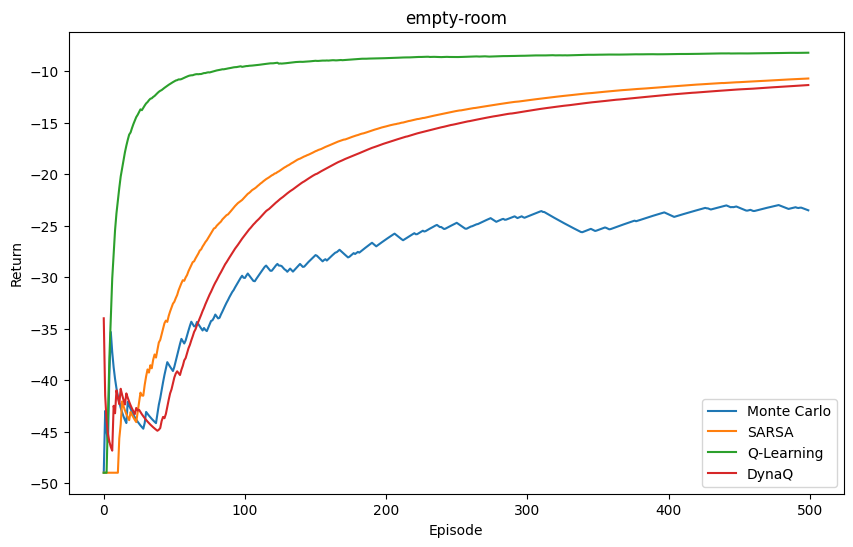

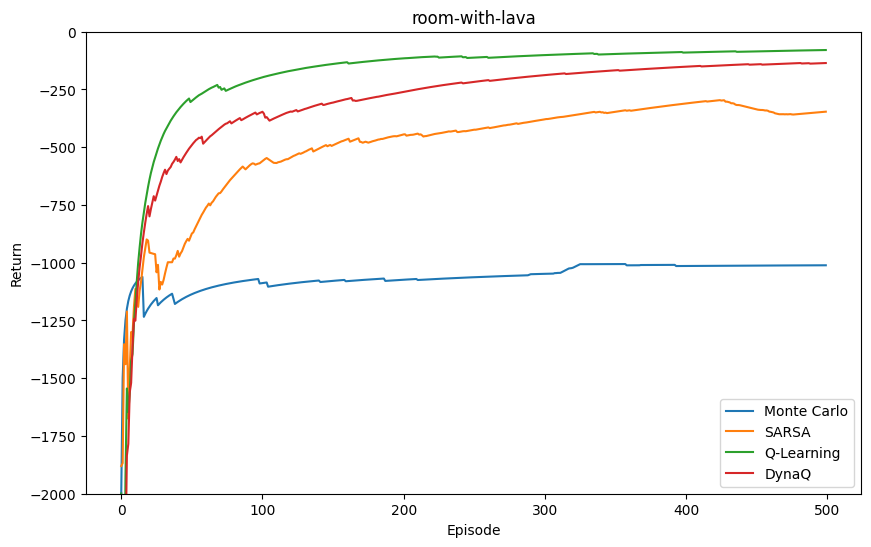

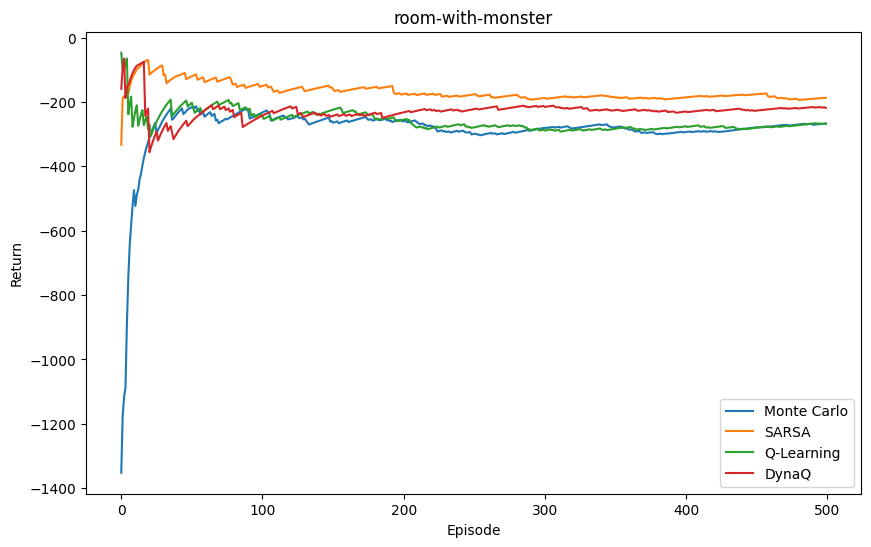

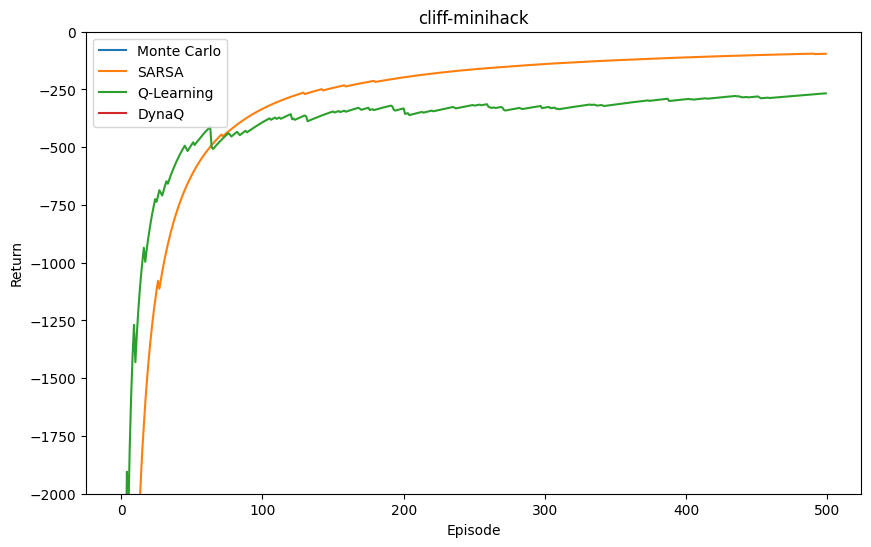

In [11]:
for i in range(len(modelReturns)):
    interactPlot = plt.figure(figsize=(10, 6))
    plt.title(environmentsName[i])
    plt.xlabel('Episode')
    plt.ylabel('Return')  
    for j in range(len(modelReturns[i])):
        plt.plot(modelReturns[j][i], label=modelsName[j])
        if min(modelReturns[j][i]) < -2000:
            plt.ylim(-2000,0)
    plt.legend()
    plt.show()